# Texture Normal Mapping

## SCC0251.2020.1 - Image Processing

Prof. Dr. Moacir Ponti

Renata Vinhaga dos Anjos (10295263) and Vitor Gratiere Torres (10284952)

### Description

#### How lights are calcultate for surfaces?

Before understanding what is a Normal Map, first we need to describe how Computer Graphics decides the final color for each pixel of a 3D Object. There're a lot of information stored in each vertex, from positions in 3D space to colors. Those vertices build faces, and those faces will have a fragment color, depending of the interpolation of the vertices colors.

But we have to remember that, in the real world, there are a bunch of elements beyond the natural color of a surface that determines it's visual look. One of them is the ligth influence.

One single light source next to an object will affect the intensity of faces colors, according to each ** normal**. Some calculation is done with the light rays, the normal, and the viewer position, as it's demonstrated in the Image below.

![image](https://learnopengl.com/img/lighting/basic_lighting_specular_theory.png)

For our main purpose, is necessary to understand that, each face of a 3D Object has a normal, and as it is flat, all the fragments of this face will be affected in the same way as they have the same normal. Even if it has a complex texture.
With more complex 3D meshes(big ammount of vertices), than the object will have more faces and consequently a bigger variance for the light calculation. But bigger meshes also means more computation, and time is something that needs to be spent wisely in Computer Graphics.

To solve this problem, we put our efforts in this project to understand how the Normal Map works and how we could implement it.

#### But what are Normal Maps?

The normal map is, as the name implies, a mapping for the normals of a surface. As it is explained in the follow image, instead of having a single normal for all the fragments of a flat surface, what we'll have is a per fragment ("per pixel") diferent normal.

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_surfaces.png)

The brutal difference for it can be seen in the comparison below:

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_compare.png)

The geometric normal of the surface remains the same, we merely modify the surface normal used in the lighting equation[11](as showed before). Just as having a normal per vertex gives the illusion that the surface is smooth between polygons, modifying the normal per pixel changes the perception of the polygon surface itself, without modifying its geometry.
We can see a example of the benefits for it in the image below. The use of a normal map provides that the meshes can be simplified and have the same visual look as a more complex mesh.

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_comparison.png)

#### The look of a normal map and how it works

![image](https://docs.unity3d.com/uploads/Main/BumpMapColourMapStoneWallExample.jpg)

#### Implementing the Normal Map from Textures

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# ^ Interact imports

import imageio
import matplotlib.pyplot as plt
import numpy as np

__author__ = ['Renata Vinhaga', 'Vitor Gratiere']

In [2]:
img = imageio.imread(str(input()).rstrip())  # take a texture image as input
img = np.asarray(img, dtype=float)

/home/ava/documents/documents/classes/nm/NormalMapping/images/TextureTest.jpg


In [3]:
def map_values(image, newMin=0, newMax=255):
    """Maps matrix's values from [`originalMin`, `originalMax`] to [`newMin`, `newMax`]"""
    a = np.min(image)
    b = np.max(image)
    return ((image - a) * ((newMax - newMin) / (b - a)) + newMin)


def map_values_rgb(image, newMin=0, newMax=255):
    """Applies `map_values` to each channel on RGB separetedly"""
    for i in range(0, 3):
        image[:, :, i] = map_values(
            image[:, :, i], newMin=newMin, newMax=newMax)
        return image

#### Step 1 - Convert image to Gray Scale

One of the details that we descovered to get better results is that,
first we need to convert the texture for a gray scale image (if it is in
RGB system). In this way, the range of values is smaller, so the change
of them is more visible.

In [4]:
def rgb_to_gray(rgb):
    """Converts coloured image to gray scale"""
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = np.zeros(np.array(rgb.shape)[0:2])
    # gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return gray

(-0.5, 358.5, 355.5, -0.5)

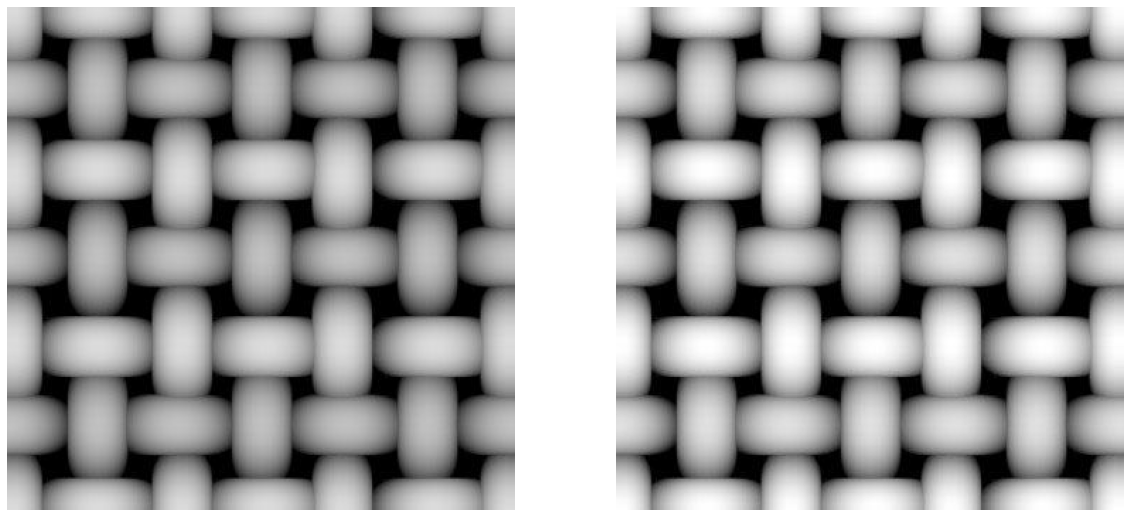

In [5]:
gray_img = rgb_to_gray(img)

plt.figure(figsize=(20, 20))

plt.subplot(121)
plt.imshow(img.astype(np.uint8))
plt.axis('off')

plt.subplot(122)
plt.imshow(gray_img, cmap="gray")
plt.axis('off')

#### [Optional] Step 2 - Blurring the image

The Sobel Operator is a very sensitive filter and any noise can render a low quality light reflection diminishing the aesthetic of the final render, Gaussian Filter's blur can help us, but for this example we won't use it.

In [6]:
def gaussian_filter(image, kernelWidth=3, sigma=150):
    """Convolutes a Gaussian Filter to blur the image"""

    def e(x, y):
        """Euclidean distance between `x` and `y`"""
        return np.sqrt(x**2 + y**2)

    def kernel(x, s):
        """Gaussian Kernel at `x`"""
        return np.exp((-(x**2)) / (2 * (s**2))) / (2 * np.pi * (s**2))

    # padding lenght
    pad = int(np.floor(kernelWidth / 2))

    # original image dimensions
    ix, iy = image.shape

    # final image
    ans = np.array([[0.0 for y in range(0, iy)] for x in range(0, ix)])

    # range to create spatial kernel component
    # it creates ranges like [-2, -1, 0, 1, 2] for n == 5
    nrng = range(int(np.ceil(-kernelWidth / 2)), int(np.ceil(kernelWidth / 2)))

    # spatial kernel component
    sgc = np.array([[kernel(e(x, y), sigma) for y in nrng] for x in nrng])

    # padding
    image = np.pad(image, pad, 'constant').astype(np.float)

    # for each index in image avoiding the pad
    for i in range(pad, ix + pad):
        for j in range(pad, iy + pad):

            # range kernel component for each neighborhood
            # it subtracts the middle value from each valeu in the neighborhood
            # and applies it to the kernel, and creates a new matrix, rgc
            rgc = np.array([[kernel(image[x, y] - image[i, j], sigma)
                             for y in range(j - pad, j + pad + 1)]
                            for x in range(i - pad, i + pad + 1)])
            w = np.multiply(rgc, sgc)
            # multiplies windowed image and w, sums each point
            # than devides by the sum of w
            ans[i - pad,
                j - pad] = np.sum(np.multiply(image[i - pad:i + pad + 1,
                                                    j - pad:j + pad + 1],
                                              w)) / np.sum(w)
    return ans

In [7]:
# smoother_gray_img = gaussian_filter(gray_img, 5, 250)

In [8]:
# plt.figure(figsize=(20, 20))

# plt.subplot(121)
# plt.imshow(gray_img, cmap="gray")
# plt.axis('off')

# plt.subplot(122)
# plt.imshow(smoother_gray_img, cmap="gray")
# plt.axis('off')

#### Step 3 - Sobel-Feldman operator

Sobel-Feldman operator is an edge detector, it uses two 3×3 kernels which are convolved with the original image to calculate approximations of the derivatives – one for horizontal changes, and one for vertical. If we define $A$ as the source image, and $Gx$ and $Gy$ are two images which at each point contain the vertical and horizontal derivative approximations respectively, the computations are as follows:

$$G_x = \begin{bmatrix}-3 & 0 & 3\\-10 & 0 & 10\\-3 & 0 & 3\end{bmatrix}$$

$$G_y = \begin{bmatrix}-3 & -10 & -3\\0 & 0 & 0\\3 & 10 & 3\end{bmatrix}$$

Then we'll crop $A$ matrix to fit kernel's shape, iterate and convolute it.

> It is also possible to use $G_x$ and $G_y$ with 1s instead of 3s, and 2s instead of 10s, it's just a matter of factors and scales. 3s and 10s got us our best outcome so far.

The x-coordinate is defined here as increasing in the "right"-direction, and the y-coordinate is defined as increasing in the "down"-direction. At each point in the image, the resulting gradient approximations can be combined to give the gradient magnitude, using $G = \sqrt{G_x^2 + G_y^2}$. Using this information, we can also calculate the gradient's direction as $\theta = atan\left(\frac{G_y}{G_x}\right)$, this angle $\theta$ tells us the light's angle, while the $G$ vector is the light's vector itself.

The components $G_x$ and $G_y$ devided by its' square root gives us the unitary components.

The $x$ component will be depicted as our reds, while the $y$ as our greens. Our blue component comes from the height map itself. All of them are scaled to $0-255$. The last operation is to cut through the threshold.

In [9]:
def sobel(img, strength=2.5, level=7.0):
    Gx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])
    # The other possible kernel
    # Gx = np.array([[-3, 0, 3],
    #                [-10, 0, 10],
    #                [-3, 0, 3]])
    # Gy = np.array([[-3, -10, -3],
    #                [0, 0, 0],
    #                [3, 10, 3]])

    shp = np.array(img.shape)[0:2]
    img = np.pad(img, 1, 'edge')
    sob = np.zeros(shp)
    normal_map = np.zeros(np.array([shp[0], shp[1], 3]))
    for i in range(0, shp[0]):
        for j in range(0, shp[1]):
            dX = np.sum(np.multiply(Gx, img[i:i + 3, j:j + 3]))
            dY = np.sum(np.multiply(Gy, img[i:i + 3, j:j + 3]))
            dZ = 1.0 / strength * (1.0 + (2.0 ** level))
            sob[i, j] = np.sqrt(dX**2 + dY**2 + dZ**2)
            normal_map[i, j, 0] = (dX / sob[i, j] * 0.5 + 0.5) * 255.0  # red
            normal_map[i, j, 1] = (dY / sob[i, j] * 0.5 + 0.5) * 255.0  # green
            normal_map[i, j, 2] = dZ / sob[i, j] * 255.0  # blue
    sob = map_values(sob)
    normal_map = map_values_rgb(normal_map)
    return normal_map, sob

In [10]:
normal_map, sob = sobel(gray_img)
# If you've applied the gaussian blur, you can use:
# normal_map, sob = sobel(smoother_gray_img)

(-0.5, 358.5, 355.5, -0.5)

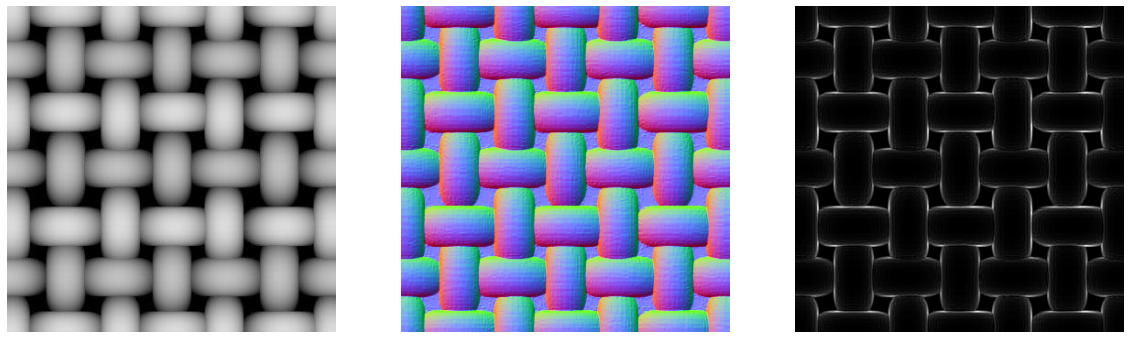

In [11]:
plt.figure(figsize=(20, 20))

plt.subplot(131)
plt.imshow(img.astype(np.uint8))
plt.axis('off')

plt.subplot(132)
plt.imshow(normal_map.astype(np.uint8))
plt.axis('off')

plt.subplot(133)
plt.imshow(sob.astype(np.uint8), cmap='gray')
plt.axis('off')

In [12]:
# imageio.imwrite('output.png', normal_map)

#### These are the RGB channels

(-0.5, 358.5, 355.5, -0.5)

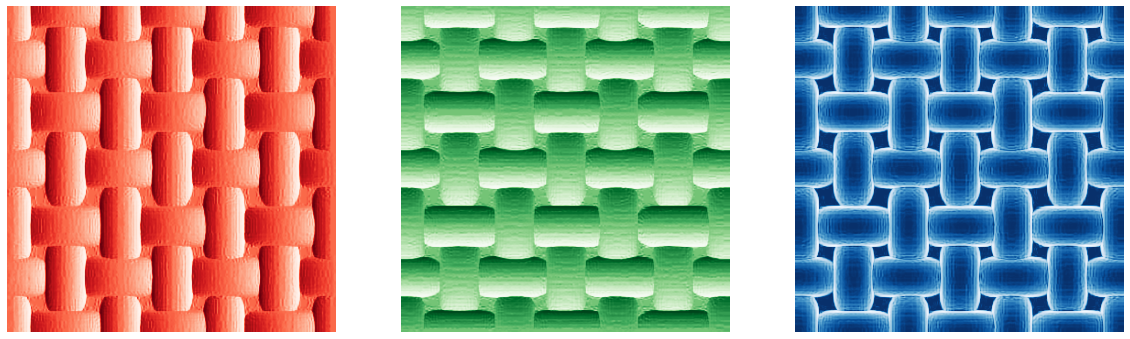

In [13]:
plt.figure(figsize=(20, 20))

plt.subplot(131)
plt.imshow(normal_map[:, :, 0], cmap="Reds")
plt.axis('off')

plt.subplot(132)
plt.imshow(normal_map[:, :, 1], cmap="Greens")
plt.axis('off')

plt.subplot(133)
plt.imshow(normal_map[:, :, 2], cmap="Blues")
plt.axis('off')

#### Step 4 - Inverting channels

It's possible that your image output looks wierd, it may be that your channels are inverted, making concave looks convex. So we got to be able to invert single channels.

In [14]:
def inv(img):
    """Invert images"""
    return 255 - img

In [15]:
def invert(red, green, rgb):
    return (red, green, rgb)
interact(invert, red=False, green=False, rgb=False);

(False, False, False)

#### TODO

- Explain tangent maps and why Sobel Operator Works
- Make interact work
- Add interact slider to sobel parameters
- Make inversions
- Check spelling
- Title graphics

#### Bibliography

##### Normal Map

[1] https://en.wikipedia.org/wiki/Lambertian_reflectance

[2] https://cpetry.github.io/NormalMap-Online/

[3] https://www.quora.com/How-are-normal-maps-made

[4] https://stackoverflow.com/questions/13983189/opengl-how-to-calculate-normals-in-a-terrain-height-grid/13983431#13983431

[5] https://en.wikipedia.org/wiki/Von_Neumann_neighborhood

[6] https://azgaar.wordpress.com/2018/02/26/image-converter/

[7] https://en.wikipedia.org/wiki/Sobel_operator

[8] http://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm

[9] https://docs.unity3d.com/Manual/StandardShaderMaterialParameterNormalMap.html

[10] K. Engel (2006). Real-time volume graphics.

[11] Moller, Haines and Naty. Real-Time Rendering (Third Edition)

##### Bump Map

https://web.archive.org/web/20060924191232/http://freespace.virgin.net/hugo.elias/graphics/x_polybm.htm

##### Canny Edge Detection

https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

https://towardsdatascience.com/implement-canny-edge-detection-from-scratch-with-pytorch-a1cccfa58bed

https://www.researchgate.net/publication/258225507_Edge_Detection_on_Polynomial_Texture_Maps

https://en.wikipedia.org/wiki/Canny_edge_detector

##### Edge Detection

https://en.wikipedia.org/wiki/Edge_detection